# Identifying Particles

Import necessary python libraries

I used absolute paths throughout this notebook, so I have commented "pwd" at every path so it can be replaced.

In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [2]:
# Imports
import deeptrack as dt
import glob 
import keras
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import math
from matplotlib import image
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import subprocess
import tensorflow as tf
import time

# Set seeds
random.seed(14)
np.random.seed(0)

print("Import Complete")

Import Complete


# Defining Constants  

### General Constants  
`VERBOSE`: Chooses how much to display. When `True` will show additional information, like model's training history plots. If `False`, hides unnecessary information.  

### Input Relevant Constants  
`NUM_OF_IMAGES`: Total number of images to load in  
`MAX_WIDTH`: Dimension of the final image to be used *after* displacing the particle  
`FRACTIONAL_UNIT`: Same value as the changed parameter in MATLAB (not the exact fractional unit). In MATLAB, the fractional unit is $2^X$, where $X$ is the value changed.  
`SIZE_OF_PARTICLE`: Approximate size of particle from the center of the image.  

### Model Training Relevant Constants  
`TEST_SIZE`: The fraction of data to be used for testing (value between 0.0 to 1.0)  
`SHUFFLE_ON`: Whether to shuffle the training/testing set  
`NUM_EPOCHS`: The number of training epochs  
`ANGLE_EPOCHS`: The number of training epochs for the angle model  

### Model Testing Relevant Constants  
`COORD_EPSILON`: The acceptable difference between predicted and actual values to be considered 'accurate'  
`LINE_LENGTH`: Length of angle line when plotting the angle in images

In [3]:
# General
VERBOSE = False # show additional information like timing and misc. print statements

# Input
NUM_OF_IMAGES    = 1000
MAX_WIDTH        = 101
FRACTIONAL_UNIT  = 1 # corresponds to the fractional unit in MATLAB (X in 2^X)
SIZE_OF_PARTICLE = 22 # 22 by 22 area in the center of the image.

# Model Training
TEST_SIZE     = 0.2
SHUFFLE_ON    = True # shuffle training/testing set
NUM_EPOCHS    = 500
ANGLE_EPOCHS  = 50

# Model Testing
COORD_EPSILON = 1.0   # acceptable difference to be considered 'accurate'
LINE_LENGTH   = 15

### General Function for Plotting History

In [4]:
def plot_history(history, ylim=2): # Thank you catkins
    """
    Plot train and validation accuracy and loss in one chart.
    :param history: The dictionary containing the accuracy and loss history.
    """
    keep = ""
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Loss and Accuracy of Train vs Validation data')
    for key, value in history.history.items():
        ax.plot(value, label=key)
        print(f'Final {key}: {round(value[-1], 3)}')
        if key == "accuracy":
            keep = value
    plt.ylim([0,ylim])
    ax.legend()
    plt.show()
    return keep

# Data Loading

## Plot one Sample Image and it's Label

In [5]:
if VERBOSE:
    # Load in single image
    # pwd single image
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

    # Convert to DeepTrack 2.0 Feature
    img_data = dt.features.Dataset(img_data)
    output_image = img_data.resolve()

    # Display image
    plt.imshow(output_image)

    # Load in Labels
    # pwd labels location
    dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
    dataset = np.array(dataset)

    dataset = dataset / 2.0 - 1
    print(dataset[:, 0:5])

    label = dataset[0]
    print(label)

    # Plot single image against label position
    plt.imshow(np.squeeze(output_image), cmap='gray')
    plt.scatter(label[1], label[0], c="r", marker="x") # 1-indexed, compensate with -1
    # plt.show()

    offsetx, offsety = label[1], label[0]
    angle = math.pi - label[2]
    x = [offsetx - LINE_LENGTH * math.cos(angle), offsetx + LINE_LENGTH * math.cos(angle)]
    y = [offsety - LINE_LENGTH * math.sin(angle), offsety + LINE_LENGTH * math.sin(angle)]
    plt.plot(x, y, '-')

    plt.show()

## Plot Multiple Sample Images and it's Labels

In [6]:
if VERBOSE:
    # ==========================================
    # Load in all images
    all_images = []
    for i in range(0, NUM_OF_IMAGES):
        image_name = 'image' + str(i + 1) + '.jpg'
        # pwd folder of images
        img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
        all_images.append(img_data)

    print("Finished loading all images")

    img_data = all_images[0]
    img_data = dt.features.Dataset(img_data)
    output_image = img_data.resolve()
    plt.imshow(np.squeeze(output_image), cmap='gray')

    # Load in Labels
    # pwd labels location
    dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
    dataset = np.array(dataset, dtype="float64")
    dataset = dataset / 2.0 - 1 # div 2 for fractional units, -1 to offset MATLAB 1-index

    # ==========================================
    # Sample a few points to show the true label
    chosen = [0, 6, 266, 977]
    for i in chosen:
        # Select image plot
        img_data = all_images[i]
        img_data = dt.features.Dataset(img_data)
        output_image = img_data.resolve()

        # Display image grayscale
        plt.imshow(np.squeeze(output_image), cmap='gray')

        # Load in label for selected data
        label = dataset[i]
        print(label)

        # Show image with true label
    #     plt.imshow(np.squeeze(output_image), cmap='gray')
    #     plt.scatter(label[1], label[0], c="r", marker="x") # 1-indexed, compensate with -1
    #     plt.show()
    original_all_images = all_images.copy()

## All Data

In [7]:
# Load in Labels
# pwd labels location
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')

dataset = np.array(dataset, dtype="float64")
dataset = dataset / (2.0**FRACTIONAL_UNIT) - 1

In [8]:
new_all_images = []

# Load in images and displace them. Update labels accordingly.
for i in range(1, NUM_OF_IMAGES + 1):
    # pwd folder of images
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image' + str(i) + '.jpg')

    particle_only = img_data[SIZE_OF_PARTICLE:-1 * SIZE_OF_PARTICLE, SIZE_OF_PARTICLE:-1 * SIZE_OF_PARTICLE]
    offset = 2 * SIZE_OF_PARTICLE
    
    rand_x = random.randint(0, 2 * SIZE_OF_PARTICLE)
    rand_y = random.randint(0, 2 * SIZE_OF_PARTICLE)
    
    displaced = np.pad(particle_only, ((rand_x, offset - rand_x), (rand_y, offset - rand_y)), 'constant')
    
    # Add new images and labels
    new_all_images.append(displaced)
    
    new_x = dataset[i - 1][0] - SIZE_OF_PARTICLE + rand_x
    new_y = dataset[i - 1][1] - SIZE_OF_PARTICLE + rand_y
    dataset[i - 1] = [new_x, new_y, dataset[i - 1][2]]
    
new_all_images = np.array(new_all_images)

(1000, 101, 101)


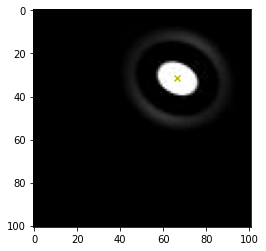

In [9]:
print(new_all_images.shape)
plt.imshow(np.squeeze(new_all_images[0]), cmap='gray')
label = dataset[0]
plt.scatter(label[1], label[0], c="y", marker="x") # 1-indexed, compensate with -1
plt.show()

## Training NN
It seems like the labels can only be a single value, so the way it is currently working on it, is to have a separate CNN for x- and y- labels. When combined, they will give the center position attribute for the cell.

In [10]:

X_train, X_test, Y_train, Y_test = train_test_split(new_all_images, dataset, test_size=TEST_SIZE, shuffle=SHUFFLE_ON)

# Labels into individual sets.
train_x_labels     = np.zeros(800)
train_y_labels     = np.zeros(800)
train_angle_labels = np.zeros(800)

test_x_labels     = np.zeros(200)
test_y_labels     = np.zeros(200)
test_angle_labels = np.zeros(200)


# Split by x, y coordinates
count = 0
for elem in Y_train:
    train_x_labels[count] = elem[0]
    train_y_labels[count] = elem[1]
    train_angle_labels[count] = elem[2]
    count += 1

count = 0
for elem in Y_test:
    test_x_labels[count] = elem[0]
    test_y_labels[count] = elem[1]
    test_angle_labels[count] = elem[2]
    count += 1

# # Converts to Tensor for model
all_images = tf.convert_to_tensor(new_all_images)
train_images = tf.convert_to_tensor(X_train)

In [11]:
def accuracy_prediction(model, train_images, test_images, train_labels, test_labels, train_acc=True, epsilon=COORD_EPSILON):
    if train_acc:
        predicted = np.array(model.predict_on_batch(train_images))
        train_labels = tf.convert_to_tensor(train_labels)

        count = 0
        for i in range(0, len(train_labels)):
            difference = round(round(predicted[i][0], 1) - float(train_labels[i]), 2)
            if abs(difference) <= epsilon:
                count += 1

        print("Training Accuracy: ", count / len(train_labels) * 100, "%")

    # 357 correct within 0.5
    # 613 correct within 1.0

    # ========
    test_images = tf.convert_to_tensor(X_test)
    test_labels = tf.convert_to_tensor(test_labels)

    predicted = np.array(model.predict_on_batch(test_images))
    
    count = 0
    for i in range(0, len(test_labels)):
        difference = round(round(predicted[i][0], 1) - float(test_labels[i]), 2)
        if abs(difference) <= epsilon:
            count += 1
    test_accuracy_percent = count / len(test_labels) * 100
    print("Test Accuracy", test_accuracy_percent, "%")
    return test_accuracy_percent

## Model Set-Up

In [12]:
x_model = dt.models.convolutional(
    input_shape=(MAX_WIDTH, MAX_WIDTH, 1), 
    conv_layers_dimensions=(1,),
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['mean_squared_error'],
    output_activation="linear",
)

if VERBOSE:
    print("Model summary:")
    x_model.summary()

y_model = dt.models.convolutional(
    input_shape=(MAX_WIDTH, MAX_WIDTH, 1), 
      conv_layers_dimensions=(1,),
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['mean_squared_error'],
    output_activation="linear",
)

if VERBOSE:
    print("Model summary:")
    y_model.summary()

angle_model = dt.models.convolutional(
    input_shape=(MAX_WIDTH, MAX_WIDTH, 1), 
    conv_layers_dimensions=(1,),
    activation_function="relu",
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['mean_squared_error'],
    output_activation="linear",
)

if VERBOSE:
    print("Model summary:")
    angle_model.summary()

## Model Training

In [13]:
def train_x(x_model):
    print("Fitting the model")
    start = time.time()
    x_history = x_model.fit(
        x=train_images,
        y=train_x_labels,
        epochs=NUM_EPOCHS,
        validation_split=0.4,
        verbose=0,
    )
    print("Model finished fitting. Took ", time.time() - start, "seconds")
    return x_history

In [14]:
def train_y(y_model):
    print("Fitting the model")
    start = time.time()
    y_history = y_model.fit(
        x=train_images,
        y=train_y_labels,
        epochs=NUM_EPOCHS,
        validation_split=0.4,
        verbose=0,
    )

    print("Model finished fitting. Took ", time.time() - start, "seconds")
    return y_history

In [15]:
def train_angle(angle_model):
    print("Fitting the model")
    start = time.time()
    angle_history = angle_model.fit(
        x=train_images,
        y=train_angle_labels,
        epochs=ANGLE_EPOCHS,
        validation_split=0.4,
        verbose=0,
    )

    print("Model finished fitting. Took ", time.time() - start, "seconds")
    return angle_history

In [16]:
x_history = train_x(x_model)
print("X-Coordinate")
test_acc = accuracy_prediction(x_model, X_train, X_test, train_x_labels, test_x_labels)

Fitting the model
Model finished fitting. Took  187.80508184432983 seconds
X-Coordinate
Training Accuracy:  8.875 %
Test Accuracy 8.5 %


In [17]:
y_history = train_y(y_model)
print("Y-Coordinate")
test_acc = accuracy_prediction(y_model, X_train, X_test, train_y_labels, test_y_labels)

Fitting the model
Model finished fitting. Took  174.4831612110138 seconds
Y-Coordinate
Training Accuracy:  62.375 %
Test Accuracy 50.0 %


In [18]:
angle_history = train_angle(angle_model)
print("Angle")

test_acc = accuracy_prediction(angle_model, X_train, X_test, train_angle_labels, test_angle_labels, epsilon=0.2)

Fitting the model
Model finished fitting. Took  17.787606954574585 seconds
Angle
Training Accuracy:  74.375 %
Test Accuracy 45.0 %


## Sample Run 
Using a chosen index `index`. 

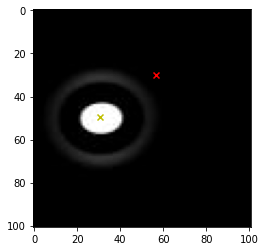

Actual -0.19379999999999997
Predicted [-0.19438368]


In [19]:
index = 123

plt.imshow(np.squeeze(X_train[index]), cmap='gray')
plt.scatter(train_y_labels[index], train_x_labels[index], c="y", marker="x") # 1-indexed, compensate with -1
x_predicted = np.array(x_model.predict_on_batch(train_images))
y_predicted = np.array(y_model.predict_on_batch(train_images))
plt.scatter(x_predicted[index], y_predicted[index], c="r", marker="x") # 1-indexed, compensate with -1
plt.show()

angle_predicted = np.array(angle_model.predict_on_batch(X_train))


print("Actual", train_angle_labels[index])
print("Predicted", angle_predicted[index])

## Plot History
Visualisation for chosen metrics over epoches for each model. Only active if `VERBOSE` is `True`.

In [20]:
if VERBOSE:
    val = plot_history(x_history)

    val = plot_history(y_history)

    val = plot_history(angle_history)

# Testing the Models
Uses a sample test walk (contained within `data/walk`), and predicts on this test walk set. Exports the plots images as separate figures, then combines into an `mp4`.

**!! Highly recommend NOT uncommenting the final block and/or making a separate folder (e.g. called `images`) to use for storing plots and animation**. When mp4 has finished creation, if the final block is uncommented, all .png files will be deleted.

In [21]:
# Load in Test Walk
walk_images = []
for i in range(0, NUM_OF_IMAGES):
    image_name = 'walk_image' + str(i + 1) + '.jpg'
    # pwd walk folder location
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/walk/' + image_name)
    walk_images.append(img_data)
walk_images = np.array(walk_images)

# Load in Labels
# pwd walk labels
walk_dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/walk_data.csv')

walk_dataset = np.array(walk_dataset, dtype="float64")
walk_dataset = walk_dataset / (2.0**FRACTIONAL_UNIT) - 1

x_predicted = np.array(x_model.predict_on_batch(walk_images))
y_predicted = np.array(y_model.predict_on_batch(walk_images))
angle_predicted = np.array(angle_model.predict_on_batch(walk_images))

x_labels = walk_dataset[:, 0]
y_labels = walk_dataset[:, 1]
angle_labels = walk_dataset[:, 2]

In [22]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [23]:
# # Generate new images
# # Quite costly (time-wise), if images already exist, I suggest not running this cell.

for index in range(0, len(walk_images)):
    # Plot real coordinates (yellow) then predicted coordinates (red) with image
    plt.scatter(y_labels[index], x_labels[index], c="y", marker="x")
    plt.scatter(y_predicted[index], x_predicted[index], c="r", marker="x")
    plt.imshow(np.squeeze(walk_images[index]), cmap='gray')
    
    # Plot angle line for real angle (yellow)
    offsetx, offsety = y_labels[index], x_labels[index]
    angle = math.pi - angle_labels[index]
    x = [offsetx - LINE_LENGTH * math.cos(angle), offsetx + LINE_LENGTH * math.cos(angle)]
    y = [offsety - LINE_LENGTH * math.sin(angle), offsety + LINE_LENGTH * math.sin(angle)]
    plt.plot(x, y, 'y-')
    plt.plot(offsetx - LINE_LENGTH * math.cos(angle), offsety - LINE_LENGTH * math.sin(angle), 'y>') # arrowhead

    # Plot angle line for predicted angle (red)
    offsetx, offsety = y_predicted[index], x_predicted[index]
    angle = math.pi - angle_predicted[index]
    x = [offsetx - LINE_LENGTH * math.cos(angle), offsetx + LINE_LENGTH * math.cos(angle)]
    y = [offsety - LINE_LENGTH * math.sin(angle), offsety + LINE_LENGTH * math.sin(angle)]
    plt.plot(x, y, 'r-')
    plt.plot(offsetx - LINE_LENGTH * math.cos(angle), offsety - LINE_LENGTH * math.sin(angle), 'r>') # arrowhead
    
    # pwd location to save images temporarily.
    #  WARNING MAKE THIS A SEPARATE FOLDER! Deleting images will delete ALL pngs in the folder.
    plt.savefig("/Users/zhimin/Courtney/winter_research/images/file%03d.png" % index)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [24]:
# Export to mp4
# pwd folder where images were temporarily saved
os.chdir("/Users/zhimin/Courtney/winter_research/images")
subprocess.call([
    'ffmpeg', '-framerate', '3', '-i', 'file%03d.png', '-r', '30', '-pix_fmt', 'yuv420p',
    'animation.mp4'
])

1

In [25]:
# # # Remove all images generated - comment out to keep the images
# for file_name in glob.glob("*.png"):
#     os.remove(file_name)